## Business Problem

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
import warnings 
warnings.filterwarnings('ignore')
import pandas_profiling
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler,PowerTransformer,LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,confusion_matrix,roc_curve,auc,plot_roc_curve
plt.style.use('ggplot')
#Module related to VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Moudles related to feature selection
from sklearn.feature_selection import RFE,SelectKBest,f_classif

## Create UDFs

In [2]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

## Import Data

In [3]:
df = pd.read_csv('E:/DataTrained/Intership_Flip Robo/final_projects/Telecom_Customer_Churn.csv') 
pd.set_option('display.max_columns',None)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Inspection

In [4]:
#profile = pandas_profiling.ProfileReport(df)
#profile.to_widgets()

In [5]:
# data informatiion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


##### TotalCharges need to be Numerical instead of categorical type

In [6]:
# Value counts for every feature to check the missing again or unique values
for i in df.columns:
    print(df[i].value_counts())
    print('**********************************')

7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64
**********************************
Male      3555
Female    3488
Name: gender, dtype: int64
**********************************
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
**********************************
No     3641
Yes    3402
Name: Partner, dtype: int64
**********************************
No     4933
Yes    2110
Name: Dependents, dtype: int64
**********************************
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64
**********************************
Yes    6361
No      682
Name: PhoneService, dtype: int64
**********************************
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
*

##### TotalCharges have 11 records with white space we need to treat that by replacing it with NAN

In [7]:
# fill the empty records with Nan
df['TotalCharges']=df['TotalCharges'].replace(" ",np.nan)

In [8]:
# convert TotalCharges data type  to Numerical and convert SeniorCitizen to categorical
df['TotalCharges']=df['TotalCharges'].astype('float64')
df['SeniorCitizen']=df['SeniorCitizen'].astype('object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


##### There are 3 datatypes;  18 objects , 2 float64 and 1 int 64 features.

In [10]:
# shape 
df.shape

(7043, 21)

##### Dataset has 7043 rows and 21 columns

In [11]:
# Check null values in  data
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

<AxesSubplot:xlabel='TotalCharges', ylabel='Density'>

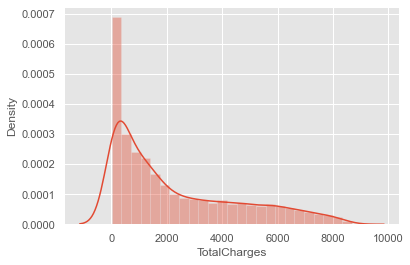

In [12]:
# check the distribution curve
sns.distplot(df['TotalCharges'])

In [13]:
# using median in filling missing values as the feature is right skewed
df['TotalCharges']=df['TotalCharges'].fillna(df.TotalCharges.median())

In [14]:
# Check null values again
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

##### Now there are no missing values.

In [15]:
# drop Loan_ID as it is unique with high cardinality feature.
df.drop('customerID',axis=1,inplace=True)

In [16]:
# Check imbalance of the target data
df.Churn.value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

##### We have some how balanced data.

In [17]:
# split train data to numerical and categorical varaiables.
num=df.select_dtypes(include=['float64','int64'])
cat=df.select_dtypes(include=['object'])

In [18]:
# Descriptive analysis for continous data
num.apply(continuous_var_summary)

,tenure,MonthlyCharges,TotalCharges
N,7043.000000,7043.000000,7.043000e+03
NMISS,0.000000,0.000000,0.000000e+00
SUM,227990.000000,456116.600000,1.607154e+07
MEAN,32.371149,64.761692,2.281917e+03
MEDIAN,29.000000,70.350000,1.397475e+03
STD,24.559481,30.090047,2.265270e+03
VAR,603.168108,905.410934,5.131450e+06
MIN,0.000000,18.250000,1.880000e+01
P1,1.000000,19.200000,1.990000e+01
P5,1.000000,19.650000,4.965000e+01


Mean and median of numerical columns are different. Skewness is present

In [19]:
# Descriptive analysis for categorical data
cat.describe(include='O')

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


## EDA

#### Univariate analysis

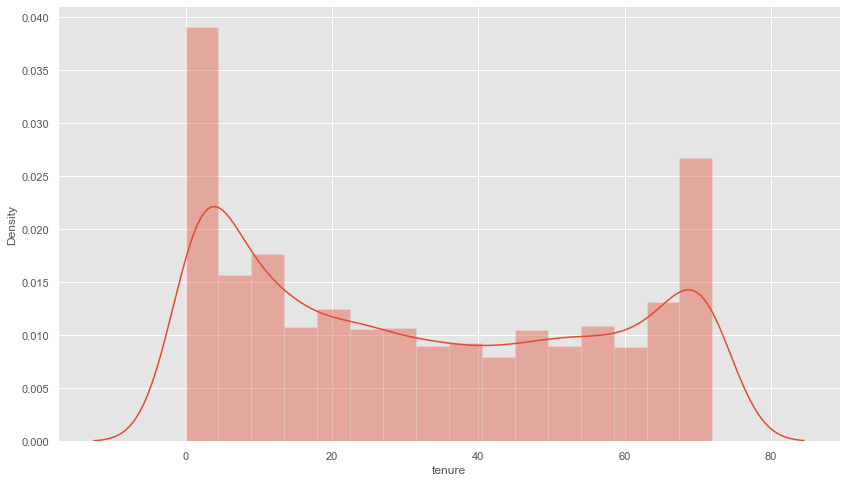

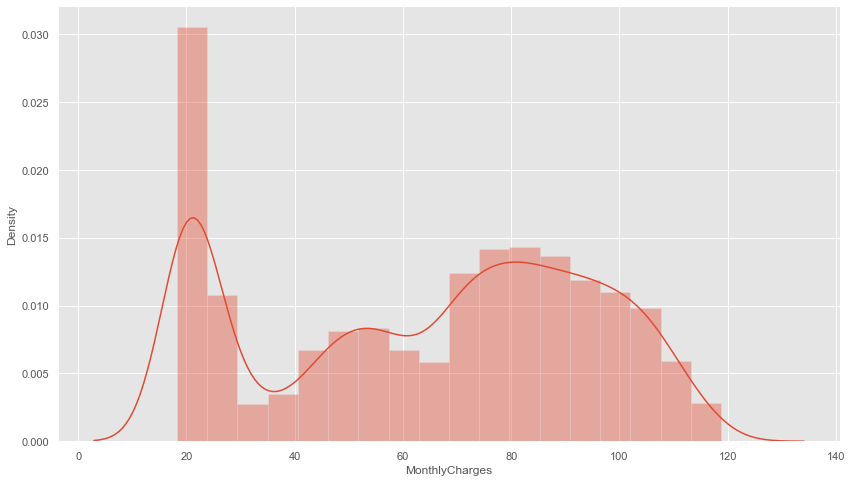

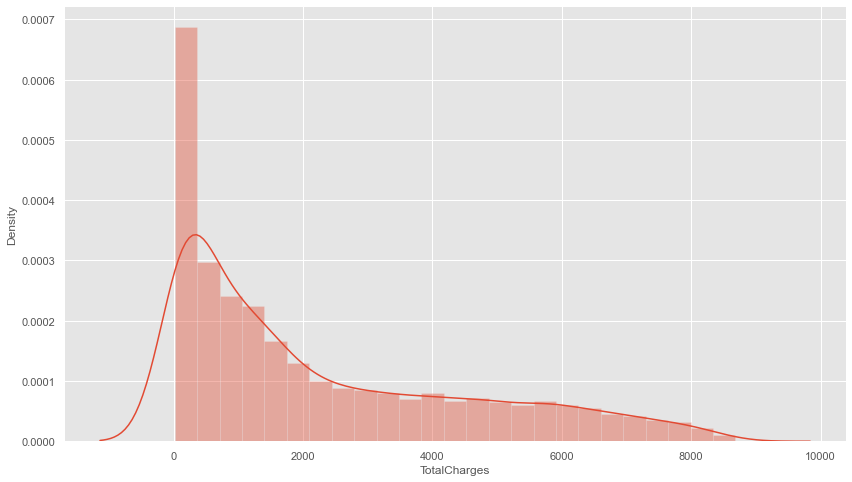

In [20]:
# Check Normality of continous data
for i in num.columns:
    plt.figure(figsize=(14,8))
    sns.distplot(df[i])
    plt.show()

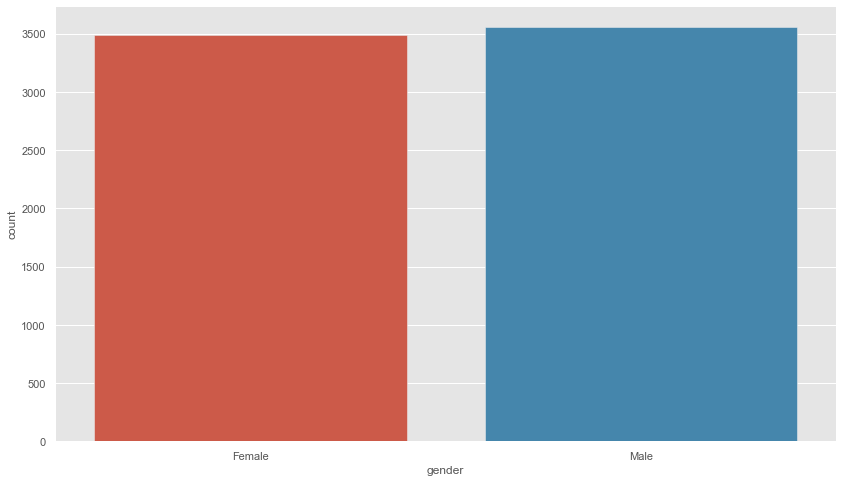

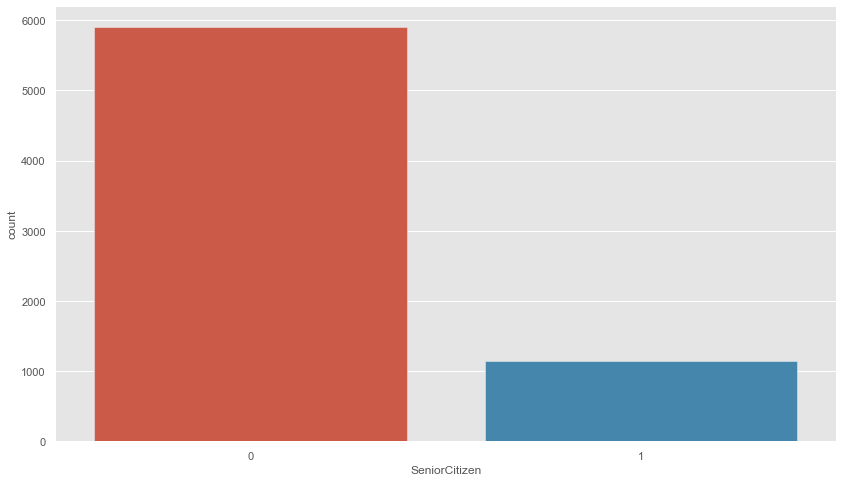

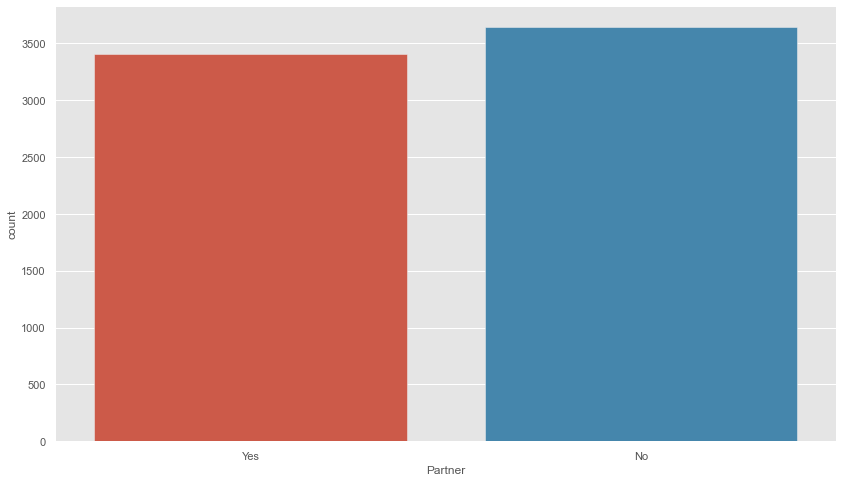

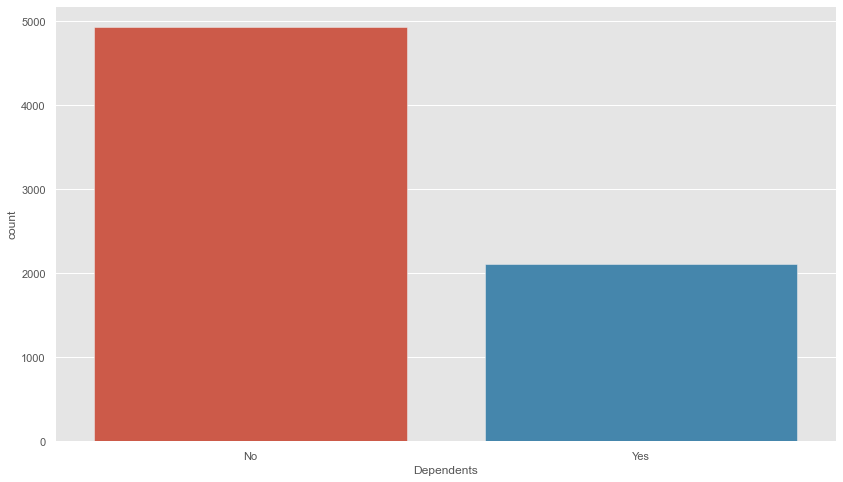

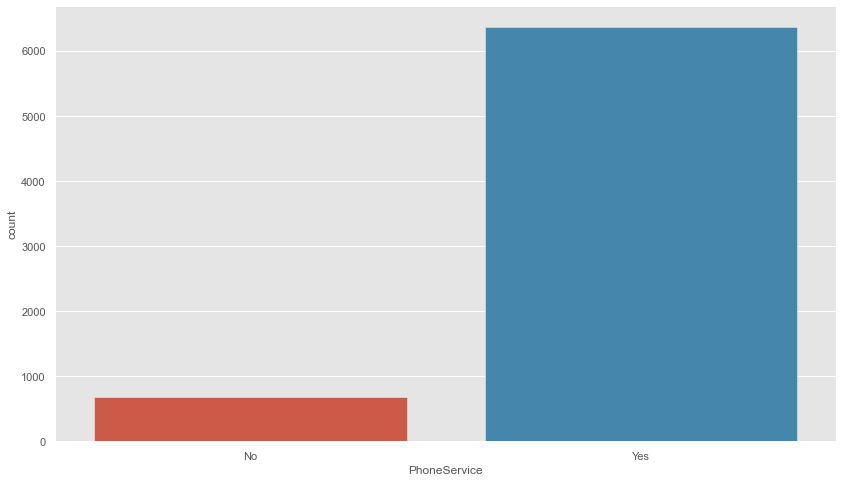

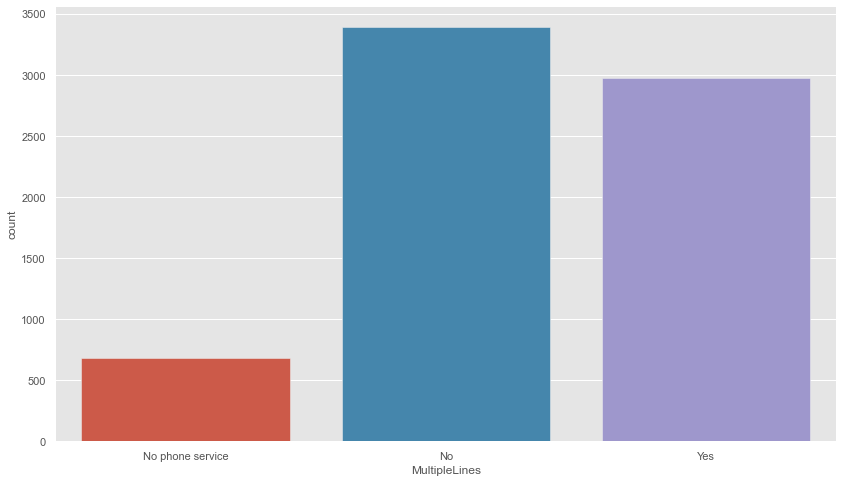

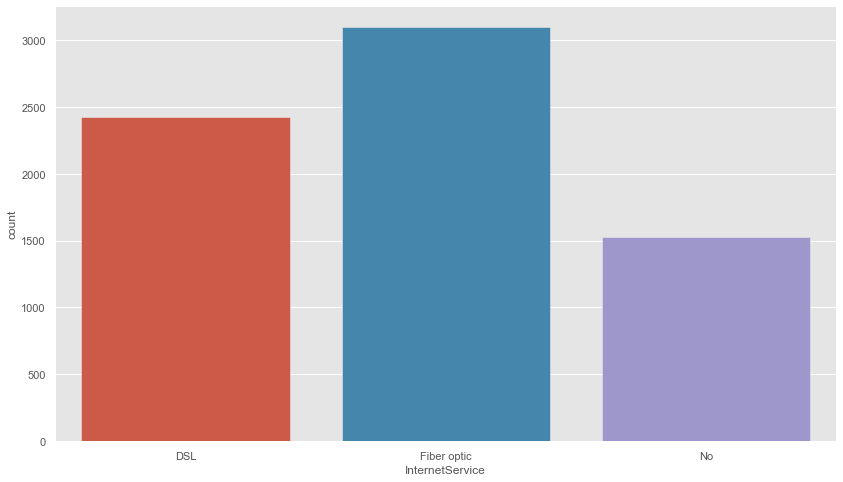

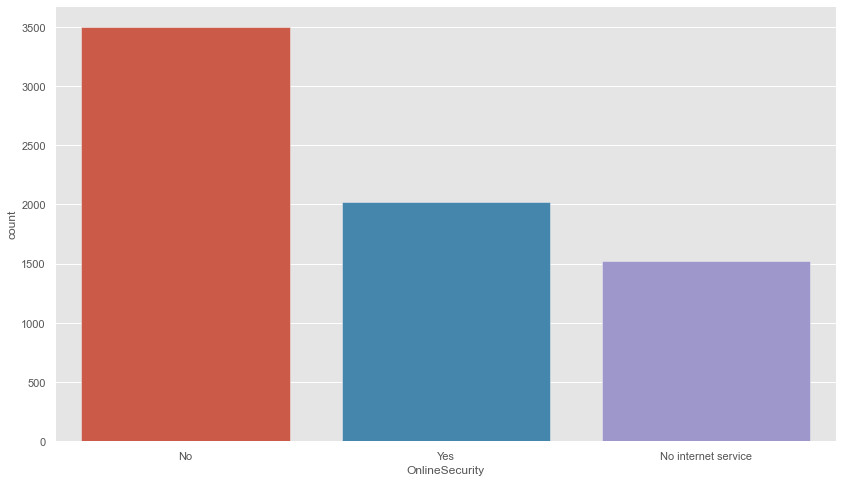

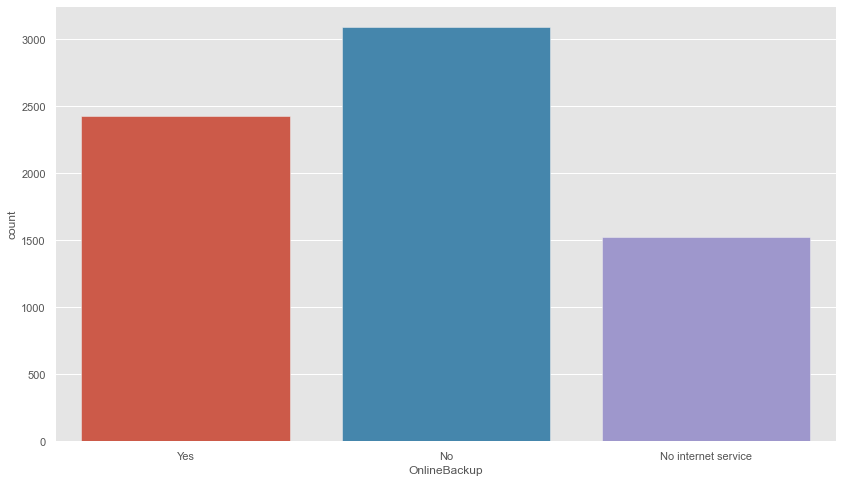

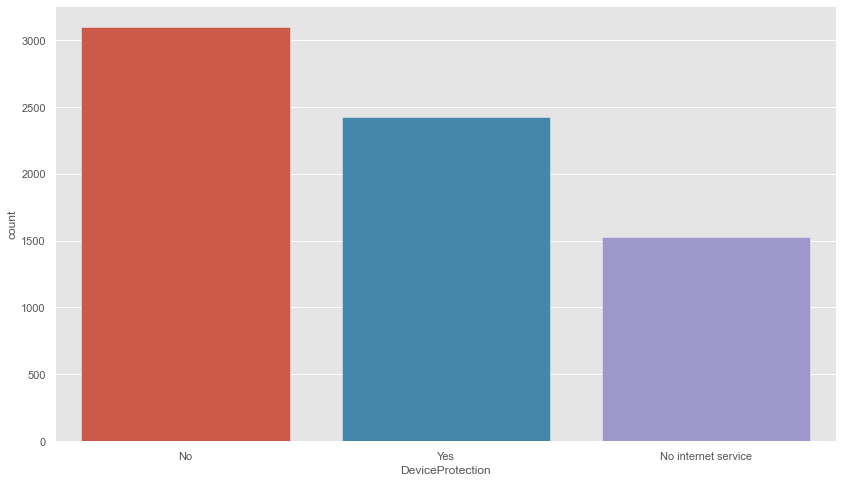

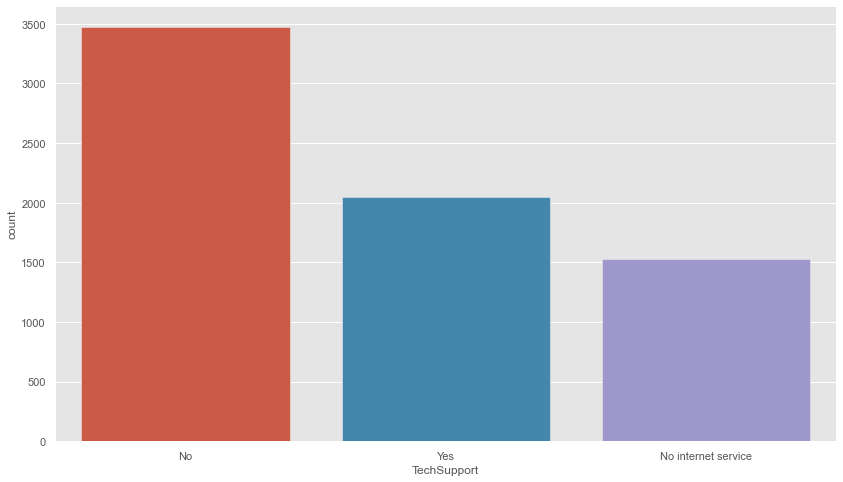

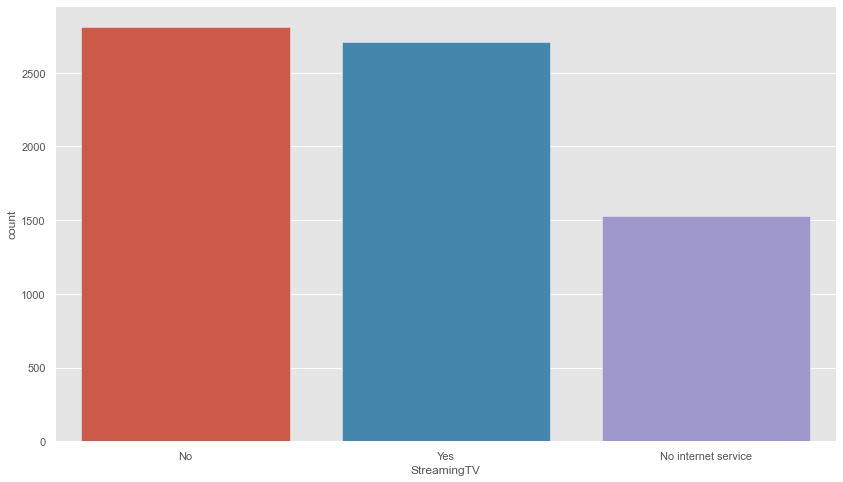

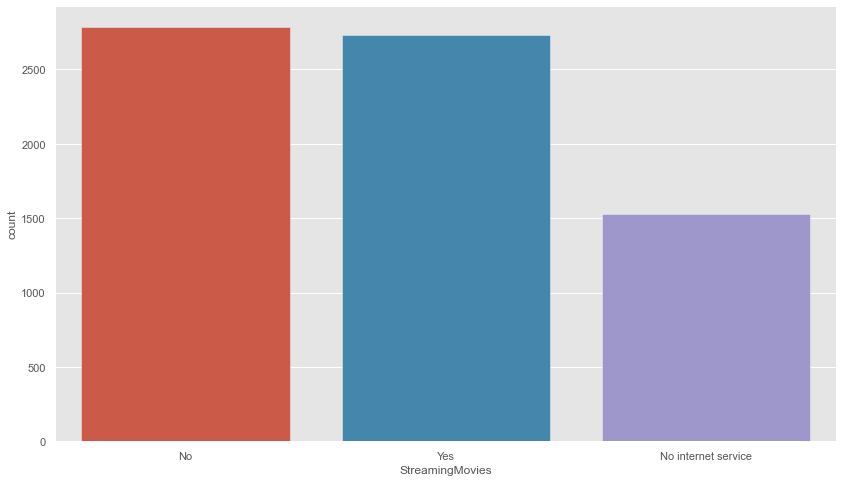

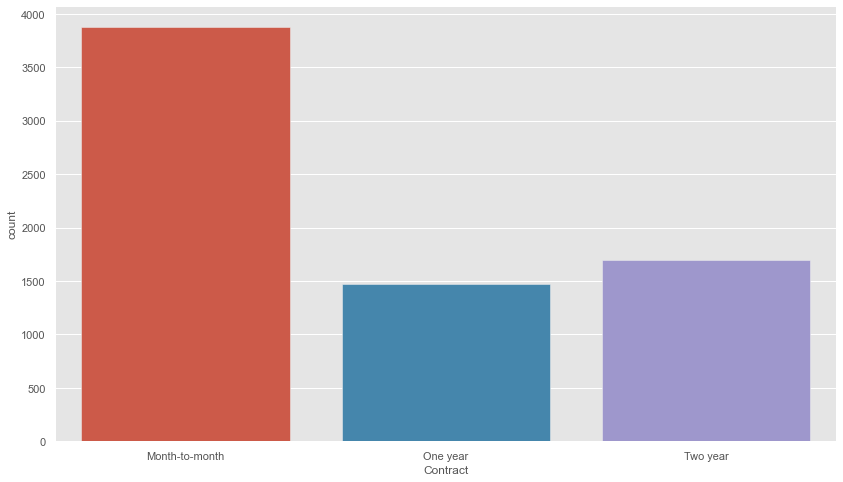

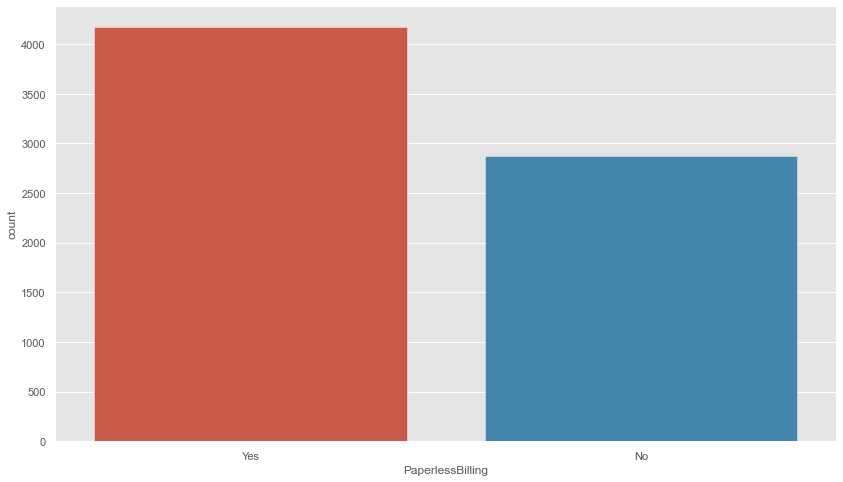

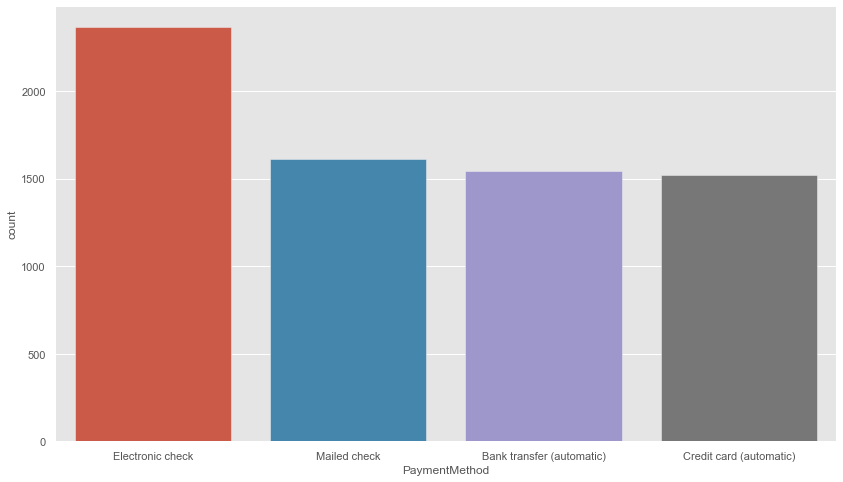

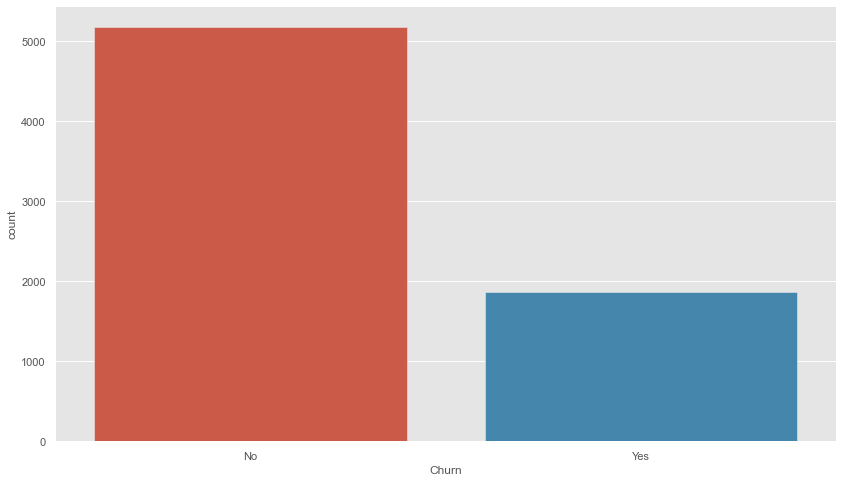

In [21]:
# Check count of categorical data
for i in cat.columns:
    plt.figure(figsize=(14,8))
    sns.countplot(df[i])
    plt.show()

We have Males slightly more than females.

Most of customers are not senir citizen.

Most of the customers have no dependents.

Almost All customers have phone services.

Fiber optic is used by many customers than DSL.

Most customers have no both online srcurity and online backup and no device protection but have streaming movioes service.

Most customers have month2month contract.

Most customers likes paperlessbilling.
Dominant in payement method is Electronic check.

According to our dataset, Customer Attrition is lesser than retention.

-------------------------------------------------------------------------------------------------------------------------------

### Bivariate analysis

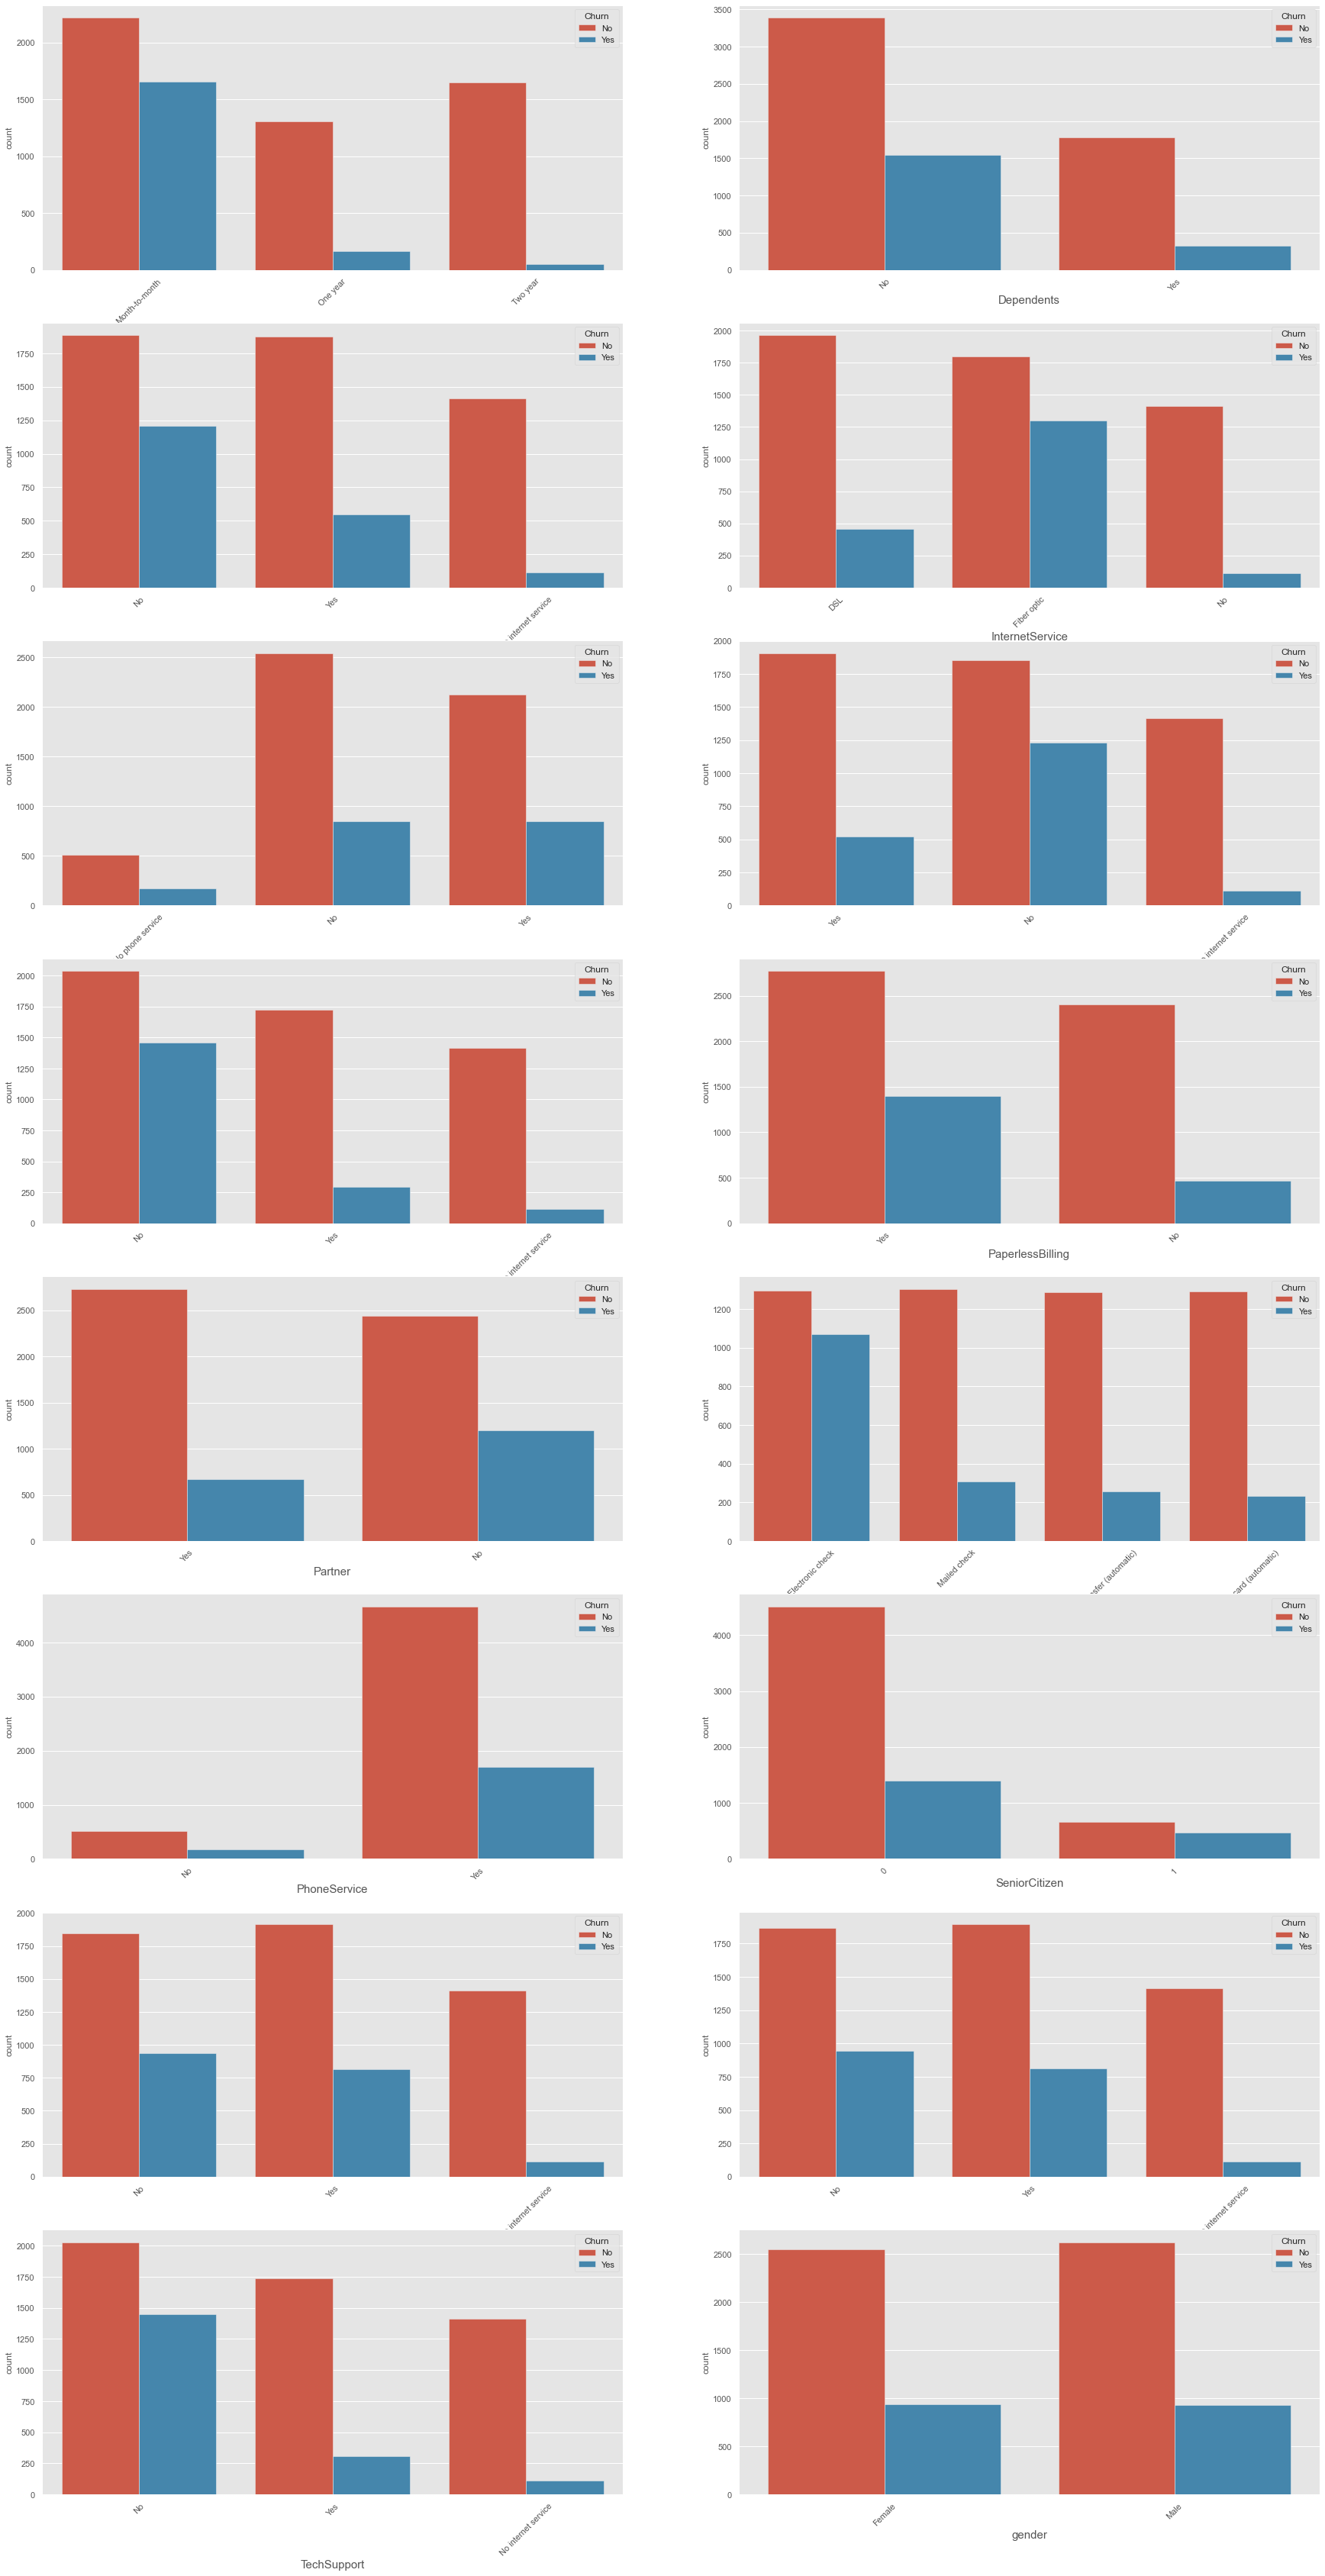

In [22]:
# Categorical variables Vs Target feature (Income)
plt.figure(figsize=(30,60), facecolor='white')
plotnumber = 1

for i in cat.columns.difference(['Churn']):
    if plotnumber<=20 :
        ax = plt.subplot(8,2,plotnumber)
        sns.countplot(x=df[i],hue=df.Churn)
        plt.xlabel(i,fontsize=15)
        plt.xticks(rotation=45)
       
    plotnumber+=1
plt.show()

Churn is lesser when no internet service option.

Churn does not depend on Phone services.

Churn is slightly more if multiple lines is taken.

Churn is lesser for the ones with nmo internet services. but this all depend on other factors and not Streaming TV and movies alone.

Churn is lesser when the customer took a partner service with thier partner.

Churn is lesser when the customer has dependents.

Churn does not depend on Gender.
Churn is more if the customer is a senior citizen.

Churn is the least when there is a contract.

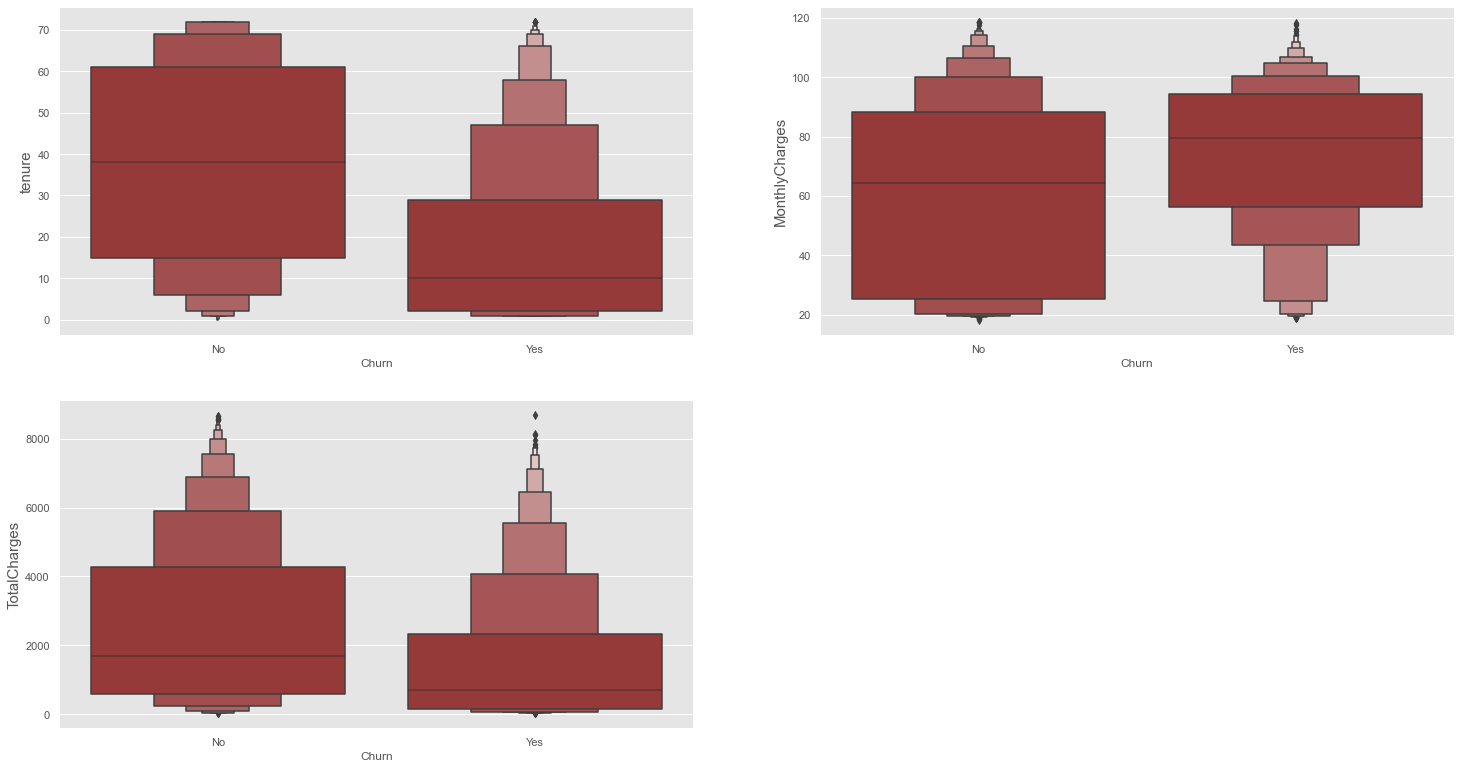

In [23]:
#lets check the numerical column and target relationship
# use boxenplot instead of warmplot for better insights
plt.figure(figsize=(25,35), facecolor='white')
plotnumber = 1

for i in num.columns:
    if plotnumber<=3 :
        ax = plt.subplot(5,2,plotnumber)
        sns.boxenplot(x=df.Churn,y=df[i],color='brown')
        plt.ylabel(i,fontsize=15)
       
    plotnumber+=1
plt.show()

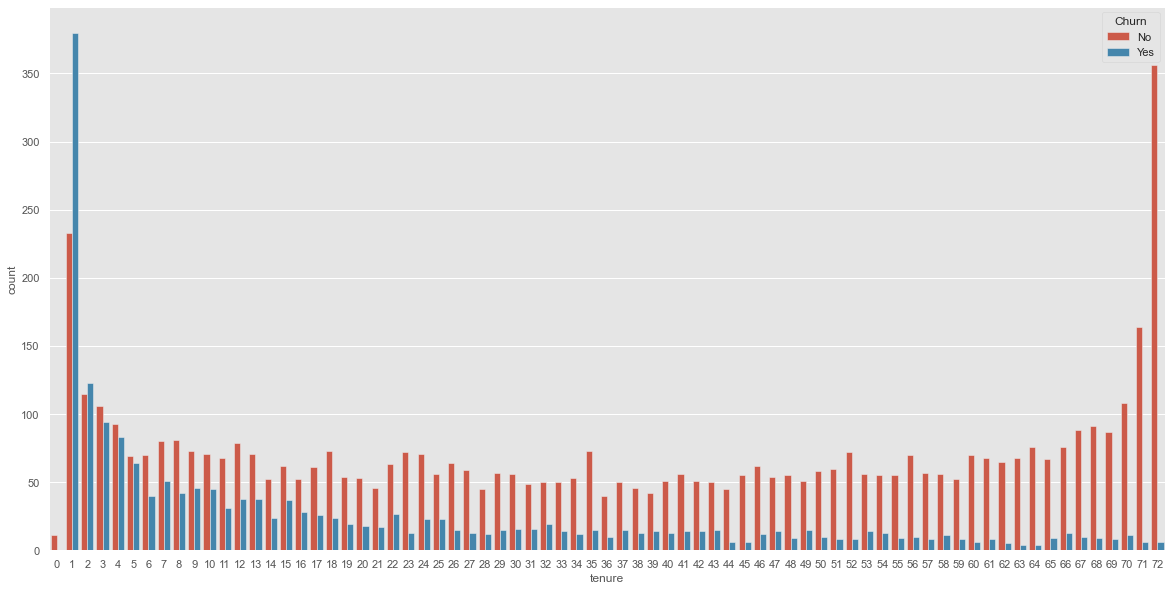

In [24]:
#lets check the detailed plot of tenure and Churn

plt.figure(figsize=(20,10))
sns.countplot(x='tenure', hue='Churn',data=df)
plt.show()

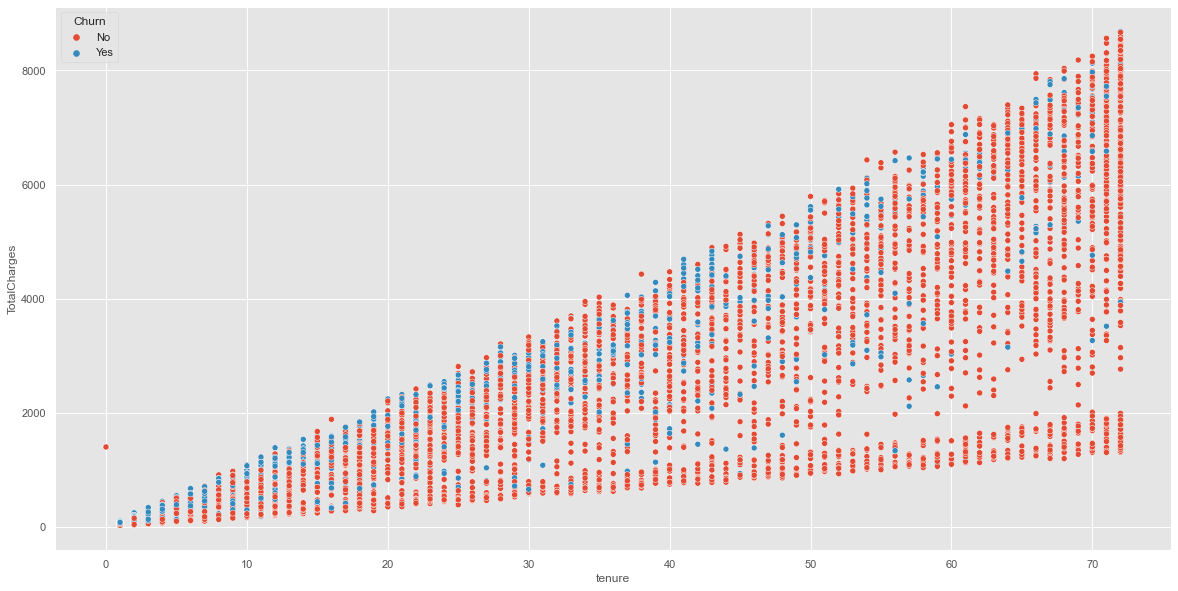

In [25]:
#lets check scatter plot of Total charges and tenure with churn

plt.figure(figsize=(20,10))
sns.scatterplot(df['tenure'],df['TotalCharges'],hue=df['Churn'])
plt.show()

-------------------------------------------------------------------------------------------------------------------------------

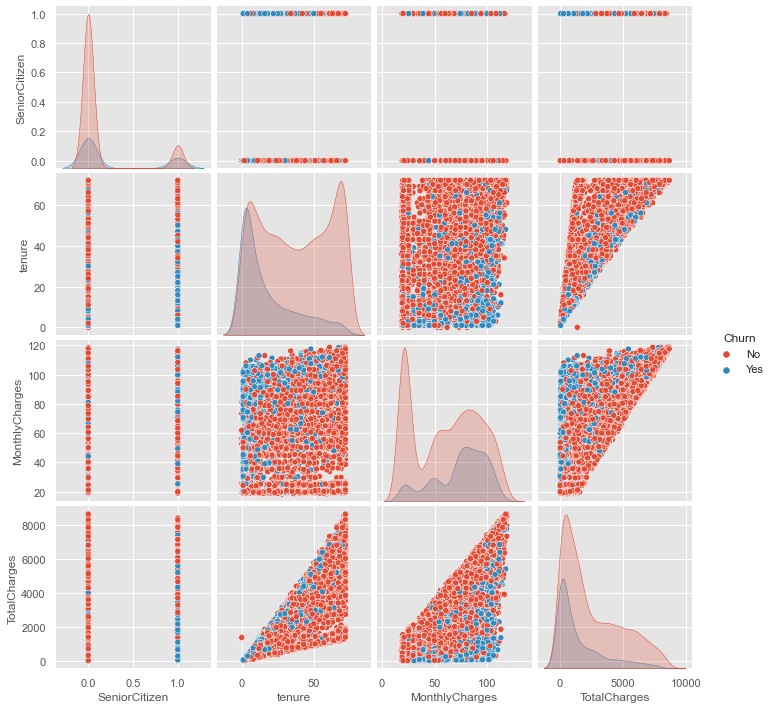

In [26]:
#pair ploting for df

sns.pairplot(df,hue="Churn")
plt.show()

------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

### Outlier Treatment

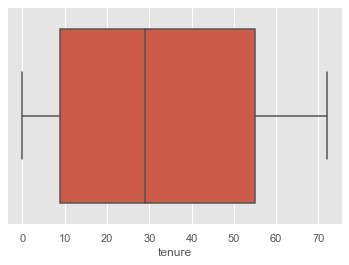

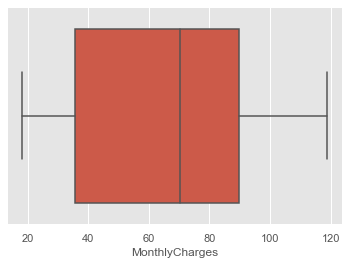

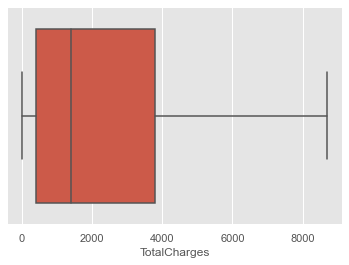

In [27]:
# Check outliers using boxplot
for col in num.columns:
    sns.boxplot(df[col])
    plt.show()

##### There are no outliers.

In [28]:
#checking the skewness

df.skew()

SeniorCitizen     1.833633
tenure            0.239540
MonthlyCharges   -0.220524
TotalCharges      0.963789
dtype: float64

In [29]:
# I'll consider -0.5/0.5 is ok among features.

skew_cols=['TotalCharges']

In [30]:
#Removing the Skewness

from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer()
df[skew_cols] = scaler.fit_transform(df[skew_cols].values)

In [31]:
#Checking the skewness again

df.skew()

SeniorCitizen     1.833633
tenure            0.239540
MonthlyCharges   -0.220524
TotalCharges     -0.144337
dtype: float64

-------------------------------------------------------------------------------------------------------------------------------

In [32]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [33]:
cat.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

In [34]:
# Encoding use getdummies.


# using label encoder for ordinal and nominal with get dummies
cat_label_encoder=cat.columns.difference(['SeniorCitizen'])


df_final=pd.get_dummies(df,columns=cat_label_encoder, drop_first=True)

In [35]:
# View final dataset
df_final

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn_Yes,Contract_One year,Contract_Two year,Dependents_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,InternetService_Fiber optic,InternetService_No,MultipleLines_No phone service,MultipleLines_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,PaperlessBilling_Yes,Partner_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PhoneService_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,StreamingTV_No internet service,StreamingTV_Yes,TechSupport_No internet service,TechSupport_Yes,gender_Male
0,0,1,29.85,-1.811104,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0
1,0,34,56.95,0.254277,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,2,53.85,-1.387090,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1
3,0,45,42.30,0.233221,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,2,70.70,-1.249770,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,0.296643,0,1,0,1,0,1,0,0,0,1,0,0,0,1,1,1,0,0,1,1,0,1,0,1,0,1,1
7039,0,72,103.20,1.567315,0,1,0,1,0,1,1,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,1,0,0,0
7040,0,11,29.60,-0.859191,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0
7041,1,4,74.40,-0.922307,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1


-------------------------------------------------------------------------------------------------------------------------------

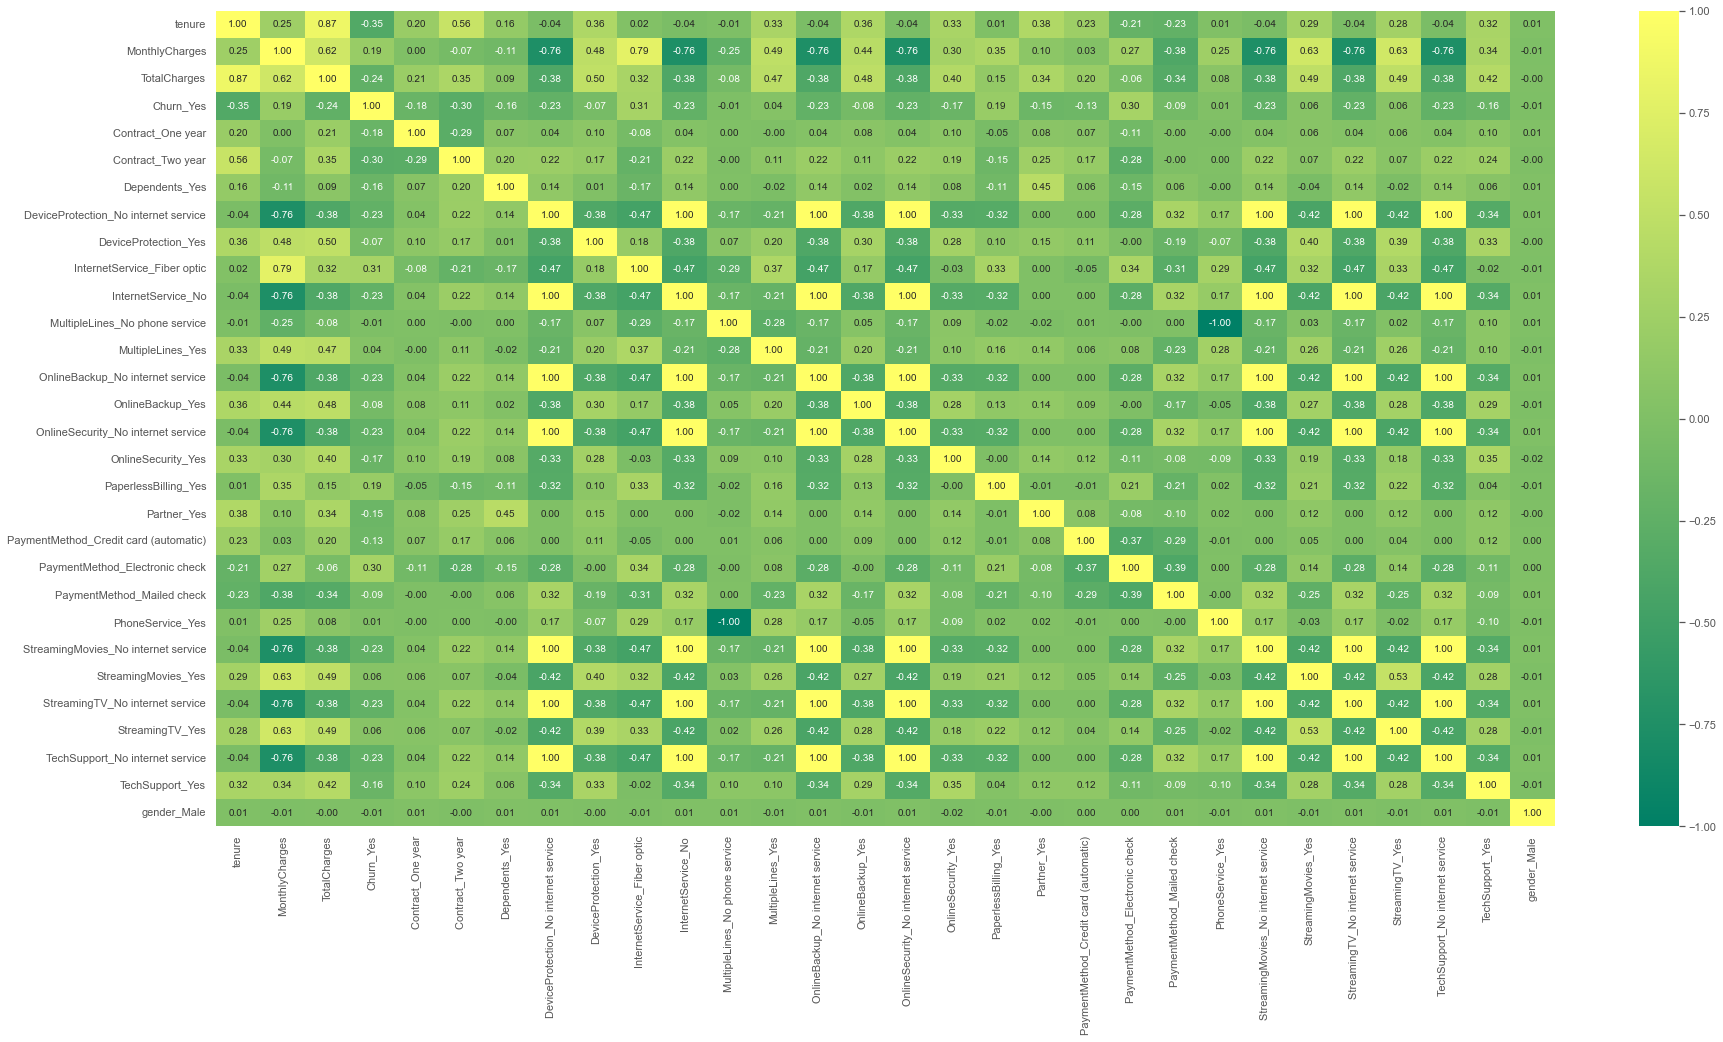

In [36]:
# heatmap correlation
plt.figure(figsize = (30,15))
sns.heatmap(df_final.corr(), annot=True,cmap='summer',fmt='.2f')
plt.show()

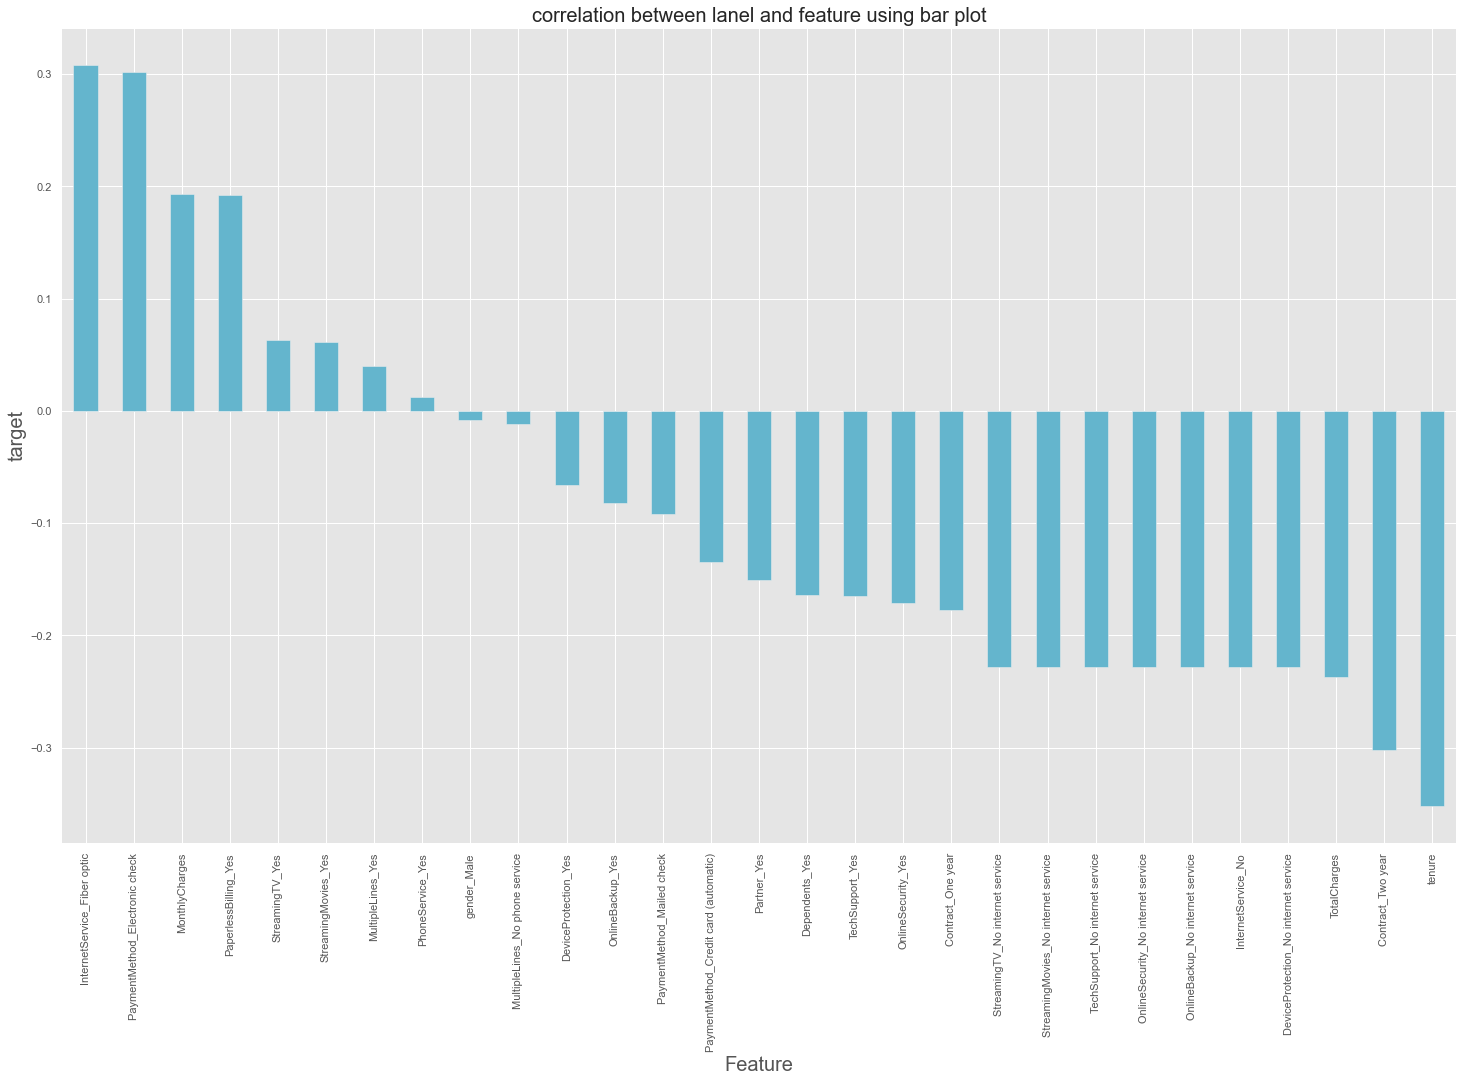

In [37]:
plt.figure(figsize = (25, 15))

df_final.corr()['Churn_Yes'].sort_values(ascending = False).drop(['Churn_Yes']).plot(kind = 'bar', color = 'c')

plt.xlabel('Feature', fontsize = 20)

plt.ylabel('target', fontsize = 20)

plt.title('correlation between lanel and feature using bar plot', fontsize = 20)

plt.show()

Multicollinearity is present in the dataset.

InternetService_Fiber optic and paymentMethod _Electronic check are the most dominant postive strong correlation between the target varaiable.

tensure is the most dominant negative strong correlation between target variable.

We may drop gender_male.

-----------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

### Feature Reduction

##### Weight of evidence & information value

In [38]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [39]:
for col in df_final.columns:
    if col == 'Churn_Yes': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        df, iv = calculate_woe_iv(df_final, col, 'Churn_Yes')
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: SeniorCitizen
IV score: 0.11


WoE and IV for column: tenure
IV score: 0.92


WoE and IV for column: MonthlyCharges
IV score: 0.75


WoE and IV for column: TotalCharges
IV score: 0.10


WoE and IV for column: Contract_One year
IV score: 0.20


WoE and IV for column: Contract_Two year
IV score: 0.84


WoE and IV for column: Dependents_Yes
IV score: 0.16


WoE and IV for column: DeviceProtection_No internet service
IV score: 0.38


WoE and IV for column: DeviceProtection_Yes
IV score: 0.02


WoE and IV for column: InternetService_Fiber optic
IV score: 0.50


WoE and IV for column: InternetService_No
IV score: 0.38


WoE and IV for column: MultipleLines_No phone service
IV score: 0.00


WoE and IV for column: MultipleLines_Yes
IV score: 0.01


WoE and IV for column: OnlineBackup_No internet service
IV score: 0.38


WoE and IV for column: OnlineBackup_Yes
IV score: 0.04


WoE and IV for column: OnlineSecurity_No internet service
IV score: 0.38


WoE and IV for column

In [40]:
df_final.columns.difference(['DeviceProtection_Yes','MultipleLines_No phone service','MultipleLines_Yes','PhoneService_Yes',
                            'StreamingMovies_Yes','StreamingTV_Yes','gender_Male','Churn_Yes'])

Index(['Contract_One year', 'Contract_Two year', 'Dependents_Yes',
       'DeviceProtection_No internet service', 'InternetService_Fiber optic',
       'InternetService_No', 'MonthlyCharges',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'PaperlessBilling_Yes', 'Partner_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'SeniorCitizen', 'StreamingMovies_No internet service',
       'StreamingTV_No internet service', 'TechSupport_No internet service',
       'TechSupport_Yes', 'TotalCharges', 'tenure'],
      dtype='object')

In [54]:
l_iv= df_final.columns.difference(['DeviceProtection_Yes','MultipleLines_No phone service','MultipleLines_Yes','PhoneService_Yes',
                            'StreamingMovies_Yes','StreamingTV_Yes','gender_Male','Churn_Yes'])

------------------------------------------------------------------------------------------------------------------------------

In [43]:
# Data split
x = df_final.drop('Churn_Yes',axis=1)
y = df_final.Churn_Yes

### Standarization

In [44]:
sc= StandardScaler()
x = pd.DataFrame(sc.fit_transform(x), columns = x.columns)
x

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Contract_One year,Contract_Two year,Dependents_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,InternetService_Fiber optic,InternetService_No,MultipleLines_No phone service,MultipleLines_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,PaperlessBilling_Yes,Partner_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PhoneService_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,StreamingTV_No internet service,StreamingTV_Yes,TechSupport_No internet service,TechSupport_Yes,gender_Male
0,-0.439916,-1.277445,-1.160323,-1.811104,-0.514249,-0.562975,-0.654012,-0.525927,-0.723968,-0.885660,-0.525927,3.054010,-0.854176,-0.525927,1.378241,-0.525927,-0.633933,0.829798,1.034530,-0.525047,1.406418,-0.544807,-3.054010,-0.525927,-0.796070,-0.525927,-0.790132,-0.525927,-0.639439,-1.009559
1,-0.439916,0.066327,-0.259629,0.254277,1.944582,-0.562975,-0.654012,-0.525927,1.381277,-0.885660,-0.525927,-0.327438,-0.854176,-0.525927,-0.725563,-0.525927,1.577454,-1.205113,-0.966622,-0.525047,-0.711026,1.835513,0.327438,-0.525927,-0.796070,-0.525927,-0.790132,-0.525927,-0.639439,0.990532
2,-0.439916,-1.236724,-0.362660,-1.387090,-0.514249,-0.562975,-0.654012,-0.525927,-0.723968,-0.885660,-0.525927,-0.327438,-0.854176,-0.525927,1.378241,-0.525927,1.577454,0.829798,-0.966622,-0.525047,-0.711026,1.835513,0.327438,-0.525927,-0.796070,-0.525927,-0.790132,-0.525927,-0.639439,0.990532
3,-0.439916,0.514251,-0.746535,0.233221,1.944582,-0.562975,-0.654012,-0.525927,1.381277,-0.885660,-0.525927,3.054010,-0.854176,-0.525927,-0.725563,-0.525927,1.577454,-1.205113,-0.966622,-0.525047,-0.711026,-0.544807,-3.054010,-0.525927,-0.796070,-0.525927,-0.790132,-0.525927,1.563872,0.990532
4,-0.439916,-1.236724,0.197365,-1.249770,-0.514249,-0.562975,-0.654012,-0.525927,-0.723968,1.129102,-0.525927,-0.327438,-0.854176,-0.525927,-0.725563,-0.525927,-0.633933,0.829798,-0.966622,-0.525047,1.406418,-0.544807,0.327438,-0.525927,-0.796070,-0.525927,-0.790132,-0.525927,-0.639439,-1.009559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.439916,-0.340876,0.665992,0.296643,1.944582,-0.562975,1.529024,-0.525927,1.381277,-0.885660,-0.525927,-0.327438,1.170719,-0.525927,-0.725563,-0.525927,1.577454,0.829798,1.034530,-0.525047,-0.711026,1.835513,0.327438,-0.525927,1.256171,-0.525927,1.265612,-0.525927,1.563872,0.990532
7039,-0.439916,1.613701,1.277533,1.567315,1.944582,-0.562975,1.529024,-0.525927,1.381277,1.129102,-0.525927,-0.327438,1.170719,-0.525927,1.378241,-0.525927,-0.633933,0.829798,1.034530,1.904590,-0.711026,-0.544807,0.327438,-0.525927,1.256171,-0.525927,1.265612,-0.525927,-0.639439,-1.009559
7040,-0.439916,-0.870241,-1.168632,-0.859191,-0.514249,-0.562975,1.529024,-0.525927,-0.723968,-0.885660,-0.525927,3.054010,-0.854176,-0.525927,-0.725563,-0.525927,1.577454,0.829798,1.034530,-0.525047,1.406418,-0.544807,-3.054010,-0.525927,-0.796070,-0.525927,-0.790132,-0.525927,-0.639439,-1.009559
7041,2.273159,-1.155283,0.320338,-0.922307,-0.514249,-0.562975,-0.654012,-0.525927,-0.723968,1.129102,-0.525927,-0.327438,1.170719,-0.525927,-0.725563,-0.525927,-0.633933,0.829798,1.034530,-0.525047,-0.711026,1.835513,0.327438,-0.525927,-0.796070,-0.525927,-0.790132,-0.525927,-0.639439,0.990532


### RFE

In [45]:
rfe = RFE(RandomForestClassifier(), n_features_to_select=14).fit(x,y)

In [46]:
l2_rfe = x.columns[rfe.get_support()]

In [47]:
l2_rfe

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'Contract_One year', 'Contract_Two year', 'InternetService_Fiber optic',
       'OnlineBackup_Yes', 'OnlineSecurity_Yes', 'PaperlessBilling_Yes',
       'Partner_Yes', 'PaymentMethod_Electronic check', 'TechSupport_Yes',
       'gender_Male'],
      dtype='object')

### SKB

In [48]:
SKB = SelectKBest(f_classif, k=14).fit(x, y )

In [49]:
l3_skb = x.columns[SKB.get_support()]

In [50]:
l3_skb

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract_Two year',
       'DeviceProtection_No internet service', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineBackup_No internet service',
       'OnlineSecurity_No internet service', 'PaperlessBilling_Yes',
       'PaymentMethod_Electronic check', 'StreamingMovies_No internet service',
       'StreamingTV_No internet service', 'TechSupport_No internet service'],
      dtype='object')

In [55]:
list(set(list(l_iv)+list(l2_rfe)+list(l3_skb)))

['StreamingTV_No internet service',
 'gender_Male',
 'tenure',
 'MonthlyCharges',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'PaymentMethod_Mailed check',
 'PaymentMethod_Credit card (automatic)',
 'PaperlessBilling_Yes',
 'Partner_Yes',
 'OnlineBackup_Yes',
 'SeniorCitizen',
 'TechSupport_Yes',
 'TotalCharges',
 'DeviceProtection_No internet service',
 'PaymentMethod_Electronic check',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'Contract_Two year',
 'StreamingMovies_No internet service',
 'Contract_One year',
 'InternetService_Fiber optic',
 'TechSupport_No internet service',
 'Dependents_Yes']

In [84]:
final_list= ['gender_Male',
 'tenure',
 'MonthlyCharges',
 'OnlineSecurity_Yes',
 #'OnlineBackup_No internet service',
 'PaymentMethod_Mailed check',
 'PaymentMethod_Credit card (automatic)',
 'PaperlessBilling_Yes',
 'Partner_Yes',
 'OnlineBackup_Yes',
 'SeniorCitizen',
 'TechSupport_Yes',
 #'TotalCharges',
 #'DeviceProtection_No internet service',
 'PaymentMethod_Electronic check',
 #'InternetService_No',
 #'OnlineSecurity_No internet service',
 'Contract_Two year',
 #'StreamingMovies_No internet service',
 'Contract_One year',
 'InternetService_Fiber optic',
 'TechSupport_No internet service',
 'Dependents_Yes']

### VIF check Multicollinarity

In [85]:
x = x[final_list]
y = y

In [86]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns

In [87]:
vif.sort_values(by='VIF_Factor', ascending=False, inplace=True)
vif

,VIF_Factor,features
2,9.815484,MonthlyCharges
14,5.054461,InternetService_Fiber optic
15,3.596366,TechSupport_No internet service
1,2.633700,tenure
12,2.592355,Contract_Two year
11,1.963741,PaymentMethod_Electronic check
4,1.839792,PaymentMethod_Mailed check
13,1.603826,Contract_One year
10,1.602985,TechSupport_Yes
5,1.559625,PaymentMethod_Credit card (automatic)


-------------------------------------------------------------------------------------------------------------------------------

##### i tried to use without balancing the data but the models was not good now try balancing the data

#### SMOTE Technique for Imbalnced Data

0    5174
1    1869
Name: Churn_Yes, dtype: int64


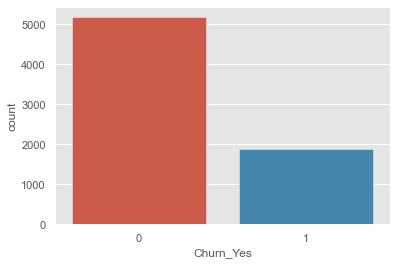

In [115]:
#Checking the count of Loan_Status

print(y.value_counts())
sns.countplot(y)
plt.show()

In [116]:
from imblearn.over_sampling import SMOTE

smt = SMOTE()
x,y = smt.fit_resample(x,y)

0    5174
1    5174
Name: Churn_Yes, dtype: int64


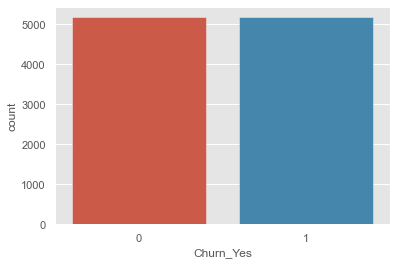

In [117]:
#Rechecking the count of Loan_Status

print(y.value_counts())
sns.countplot(y)
plt.show()

## ML Alogs

In [118]:
#Finding the Best Random State

Accu=0
RS=0
for i in range(1,100):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.25, random_state =i)
    lr=LogisticRegression()
    lr.fit(x_train, y_train)
    pred = lr.predict(x_test)
    acc=accuracy_score(y_test, pred)
    if acc>Accu:
        Accu=acc
        RS=i
print("Best accuracy is ",Accu," on Random_state ",RS)

Best accuracy is  0.7870119829918825  on Random_state  59


#### Split the data

In [127]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=59)

### Logistic Regression

In [128]:
lr.fit(x_train,y_train)
pred_train=lr.predict(x_train)
pred_test=lr.predict(x_test)
score_test=roc_auc_score(y_test,pred_test)
score_train=roc_auc_score(y_train,pred_train)
score_acc=accuracy_score(y_test,pred_test)
print('Roc_Auc train: ',score_train)
print('Roc_Auc test: ',score_test)
print('Auccuracy test: ',score_acc)
print('Confusion Matrix: ' ,'\n',confusion_matrix(y_test,pred_test))
print('Classification Report: ','\n',classification_report(y_test,pred_test))

Roc_Auc train:  0.7645543581989047
Roc_Auc test:  0.7868065285063287
Auccuracy test:  0.7870119829918825
Confusion Matrix:  
 [[ 977  306]
 [ 245 1059]]
Classification Report:  
               precision    recall  f1-score   support

           0       0.80      0.76      0.78      1283
           1       0.78      0.81      0.79      1304

    accuracy                           0.79      2587
   macro avg       0.79      0.79      0.79      2587
weighted avg       0.79      0.79      0.79      2587



### cross-validation

In [129]:
for i in range(3,11):
    cvs=cross_val_score(lr,x,y,cv=i)
    cvs_mean=cvs.mean()
    cvs_std=cvs.std()
    print ("At cv: ",i)
    print ("Cross validation score is : ",cvs_mean*100)
    print ("Cross validation score_std is : ", cvs_std*100)
    print ("accuracy Score is : ",score_acc*100)
    print ("\n")

At cv:  3
Cross validation score is :  76.97147811519967
Cross validation score_std is :  0.7201030538514217
accuracy Score is :  78.70119829918825


At cv:  4
Cross validation score is :  76.95206803247004
Cross validation score_std is :  0.577482070673703
accuracy Score is :  78.70119829918825


At cv:  5
Cross validation score is :  76.89416110375616
Cross validation score_std is :  0.9969541506744787
accuracy Score is :  78.70119829918825


At cv:  6
Cross validation score is :  76.86524989632021
Cross validation score_std is :  1.0771702486273524
accuracy Score is :  78.70119829918825


At cv:  7
Cross validation score is :  76.90385939266753
Cross validation score_std is :  0.7669295702162352
accuracy Score is :  78.70119829918825


At cv:  8
Cross validation score is :  76.8941757483824
Cross validation score_std is :  1.3743400134256183
accuracy Score is :  78.70119829918825


At cv:  9
Cross validation score is :  76.79755132587462
Cross validation score_std is :  0.9500894621

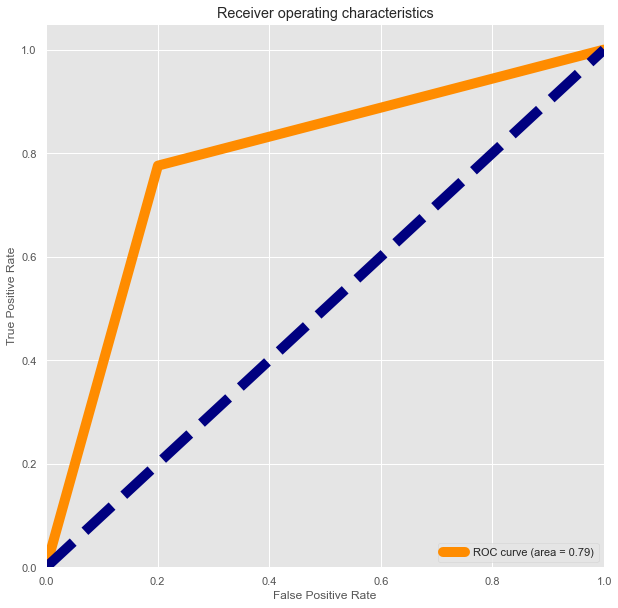

In [130]:
# ROC curve 
fpr,tpr,threshold=roc_curve(pred_test,y_test)
roc_auc=auc(fpr,tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color='darkorange',lw=10,label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=10,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

-------------------------------------------------------------------------------------------------------------------------------

### Decision Tree

In [131]:
dtc=DecisionTreeClassifier()
dtc.fit(x_train,y_train)
pred_train=dtc.predict(x_train)
pred_test=dtc.predict(x_test)
score_train=roc_auc_score(y_train,pred_train)
score_test=roc_auc_score(y_test,pred_test)
print('Roc_Auc Score_train: ',score_train)
print('Roc_Auc Score_test: ',score_test)
print('Confusion Matrix: ' ,'\n','\n',confusion_matrix(y_test,pred_test))
print('Classification Report: ','\n',classification_report(y_test,pred_test))
print('CV  : ',cross_val_score(dtc,x,y,cv=4).mean())

Roc_Auc Score_train:  0.9984503096989874
Roc_Auc Score_test:  0.7774214719144642
Confusion Matrix:  
 
 [[1009  274]
 [ 302 1002]]
Classification Report:  
               precision    recall  f1-score   support

           0       0.77      0.79      0.78      1283
           1       0.79      0.77      0.78      1304

    accuracy                           0.78      2587
   macro avg       0.78      0.78      0.78      2587
weighted avg       0.78      0.78      0.78      2587

CV  :  0.7648821028218012


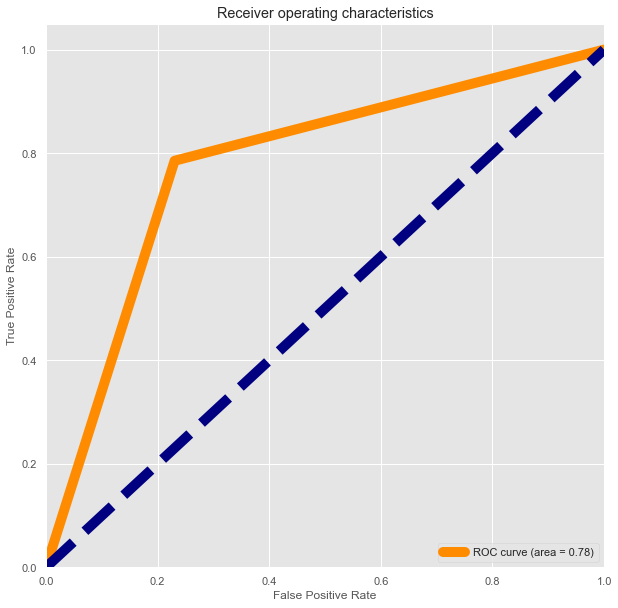

In [132]:
# ROC curve
fpr,tpr,threshold=roc_curve(pred_test,y_test)
roc_auc=auc(fpr,tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color='darkorange',lw=10,label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=10,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

-------------------------------------------------------------------------------------------------------------------------------

### SVM

In [133]:
svc= SVC()
svc.fit(x_train,y_train)
pred_train=svc.predict(x_train)
pred_test=svc.predict(x_test)
score_test=roc_auc_score(y_test,pred_test)
score_train=roc_auc_score(y_train,pred_train)
print('Roc_Auc train: ',score_train)
print('Roc_Auc test: ',score_test)
print('Confusion Matrix: ' ,'\n',confusion_matrix(y_test,pred_test))
print('Classification Report: ','\n',classification_report(y_test,pred_test))
print('CV  : ',cross_val_score(svc,x,y,cv=4).mean())

Roc_Auc train:  0.8110689745168238
Roc_Auc test:  0.8061038282591129
Confusion Matrix:  
 [[ 997  286]
 [ 215 1089]]
Classification Report:  
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      1283
           1       0.79      0.84      0.81      1304

    accuracy                           0.81      2587
   macro avg       0.81      0.81      0.81      2587
weighted avg       0.81      0.81      0.81      2587

CV  :  0.7929068419018168


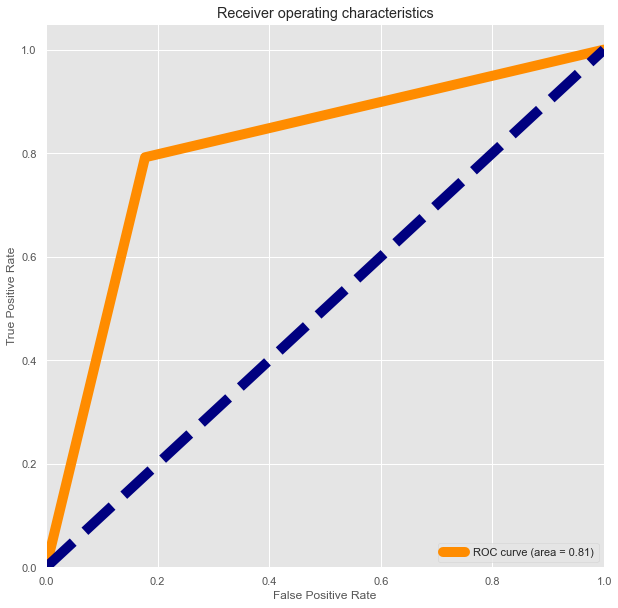

In [134]:
# ROC curve
fpr,tpr,threshold=roc_curve(pred_test,y_test)
roc_auc=auc(fpr,tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color='darkorange',lw=10,label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=10,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

------------------------------------------------------------------------------------------------------------------------------

### KNN

In [144]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
knn.fit(x_train,y_train)
pred_train=knn.predict(x_train)
pred_test=knn.predict(x_test)
score_test=roc_auc_score(y_test,pred_test)
score_train=roc_auc_score(y_train,pred_train)
print('Roc_Auc train: ',score_train)
print('Roc_Auc test: ',score_test)
print('Auccuracy test: ',score_acc)
print('Confusion Matrix: ' ,'\n',confusion_matrix(y_test,pred_test))
print('Classification Report: ','\n',classification_report(y_test,pred_test))
print('CV  : ',cross_val_score(knn,x,y,cv=4).mean())

Roc_Auc train:  0.8545874100239274
Roc_Auc test:  0.7906916902964198
Auccuracy test:  0.7870119829918825
Confusion Matrix:  
 [[ 924  359]
 [ 181 1123]]
Classification Report:  
               precision    recall  f1-score   support

           0       0.84      0.72      0.77      1283
           1       0.76      0.86      0.81      1304

    accuracy                           0.79      2587
   macro avg       0.80      0.79      0.79      2587
weighted avg       0.80      0.79      0.79      2587

CV  :  0.794163123308852


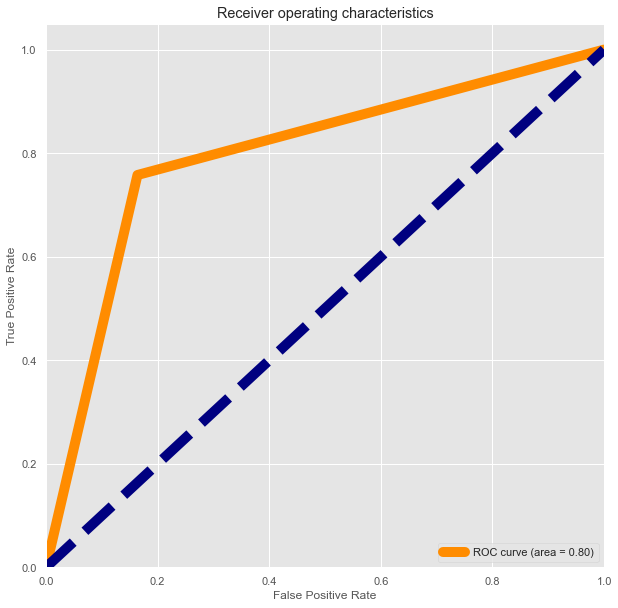

In [145]:
# ROC curve
fpr,tpr,threshold=roc_curve(pred_test,y_test)
roc_auc=auc(fpr,tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color='darkorange',lw=10,label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=10,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

-------------------------------------------------------------------------------------------------------------------------------

### Ensembles Techniques

### Random Forest Classifier

In [137]:
rfc= RandomForestClassifier()
rfc.fit(x_train,y_train)
pred_train=rfc.predict(x_train)
pred_test=rfc.predict(x_test)
score_test=roc_auc_score(y_test,pred_test)
score_train=roc_auc_score(y_train,pred_train)
print('Roc_Auc train: ',score_train)
print('Roc_Auc test: ',score_test)
print('Confusion Matrix: ' ,'\n',confusion_matrix(y_test,pred_test))
print('Classification Report: ','\n',classification_report(y_test,pred_test))
print('CV  : ',cross_val_score(rfc,x,y,cv=4).mean())

Roc_Auc train:  0.9984537961784201
Roc_Auc test:  0.836451125860115
Confusion Matrix:  
 [[1067  216]
 [ 207 1097]]
Classification Report:  
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      1283
           1       0.84      0.84      0.84      1304

    accuracy                           0.84      2587
   macro avg       0.84      0.84      0.84      2587
weighted avg       0.84      0.84      0.84      2587

CV  :  0.8428681870892927


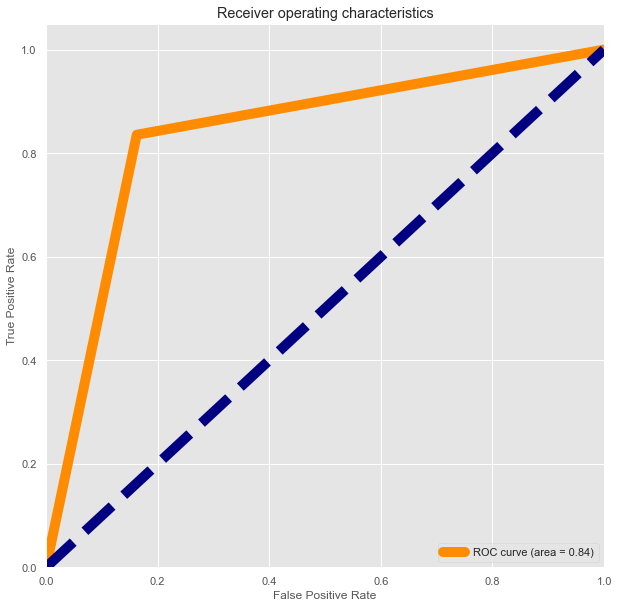

In [138]:
# ROC curve
fpr,tpr,threshold=roc_curve(pred_test,y_test)
roc_auc=auc(fpr,tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color='darkorange',lw=10,label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=10,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

-------------------------------------------------------------------------------------------------------------------------------

### GBC

In [161]:
gbc=GradientBoostingClassifier()
gbc.fit(x_train,y_train)
pred_test=gbc.predict(x_test)
pred_train=gbc.predict(x_train)
score_test=roc_auc_score(y_test,pred_test)
score_train=roc_auc_score(y_train,pred_train)
print('Roc_Auc train: ',score_train)
print('Roc_Auc test: ',score_test)
print('Confusion Matrix: ' ,'\n',confusion_matrix(y_test,pred_test))
print('Classification Report: ','\n',classification_report(y_test,pred_test))
print('CV  : ',cross_val_score(gbc,x,y,cv=4).mean())

Roc_Auc train:  0.8373879096862368
Roc_Auc test:  0.8353955572876072
Confusion Matrix:  
 [[1021  262]
 [ 163 1141]]
Classification Report:  
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      1283
           1       0.81      0.88      0.84      1304

    accuracy                           0.84      2587
   macro avg       0.84      0.84      0.84      2587
weighted avg       0.84      0.84      0.84      2587

CV  :  0.8215114031696947


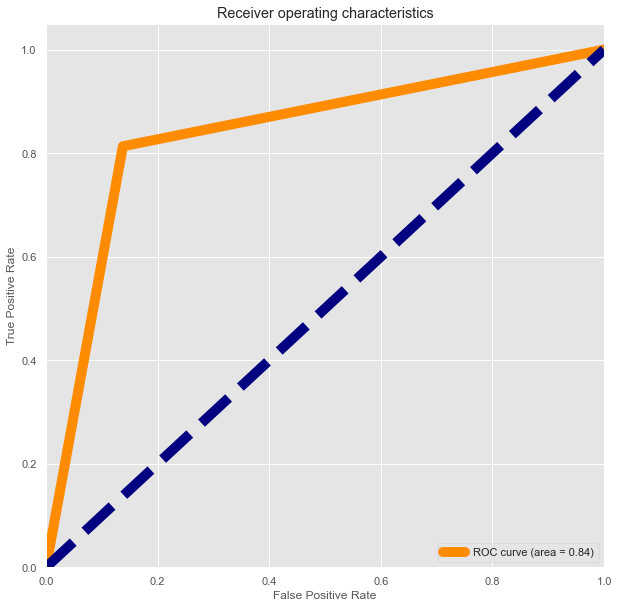

In [162]:
# ROC curve
fpr,tpr,threshold=roc_curve(pred_test,y_test)
roc_auc=auc(fpr,tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color='darkorange',lw=10,label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=10,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

-------------------------------------------------------------------------------------------------------------------------------

### XGboost

In [163]:
xgb= XGBClassifier()
xgb.fit(x_train,y_train)
pred_test=xgb.predict(x_test)
pred_train=xgb.predict(x_train)
score_test=roc_auc_score(y_test,pred_test)
score_train=roc_auc_score(y_train,pred_train)
print('Roc_Auc train: ',score_train)
print('Roc_Auc test: ',score_test)
print('Confusion Matrix: ' ,'\n',confusion_matrix(y_test,pred_test))
print('Classification Report: ','\n',classification_report(y_test,pred_test))
print('CV  : ',cross_val_score(xgb,x,y,cv=4).mean())

Roc_Auc train:  0.9344545851189089
Roc_Auc test:  0.8488654132138536
Confusion Matrix:  
 [[1090  193]
 [ 198 1106]]
Classification Report:  
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1283
           1       0.85      0.85      0.85      1304

    accuracy                           0.85      2587
   macro avg       0.85      0.85      0.85      2587
weighted avg       0.85      0.85      0.85      2587

CV  :  0.827212988017008


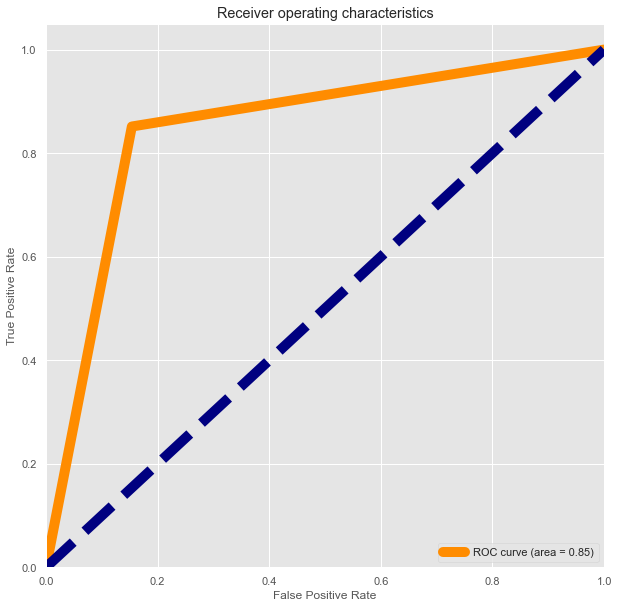

In [164]:
# ROC curve
fpr,tpr,threshold=roc_curve(pred_test,y_test)
roc_auc=auc(fpr,tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color='darkorange',lw=10,label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=10,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

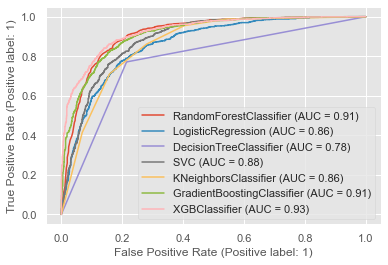

In [150]:
# Plotting AUC-ROC Curve for all the models used here 

from sklearn.metrics import plot_roc_curve 

disp = plot_roc_curve(rfc,x_test,y_test)
plot_roc_curve(lr, x_test, y_test, ax=disp.ax_)    
plot_roc_curve(dtc,x_test, y_test, ax=disp.ax_)
plot_roc_curve(svc, x_test, y_test, ax=disp.ax_)
plot_roc_curve(knn, x_test, y_test, ax=disp.ax_)
plot_roc_curve(gbc, x_test, y_test, ax=disp.ax_)
plot_roc_curve(xgb, x_test, y_test, ax=disp.ax_)

plt.legend(prop={'size':11}, loc='lower right')
plt.show()

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------

#### Hyperparameter Tuning 

In [151]:
# tunning XGBClassifier

param_xgb={'learning_rate':[0.001,0.01,0.1,1],'n_estimators':[100,250,500,700,1000],'max_depth':[3,5,7,9],'subsample':[0.7,0.9],
           'colsample_bytree':[0.7,0.9],'min_child_weight':[1,3]}

xgb_model=GridSearchCV(XGBClassifier(),param_xgb,cv=4,n_jobs=-1,scoring='roc_auc',verbose=True).fit(x_train,y_train)

Fitting 4 folds for each of 640 candidates, totalling 2560 fits


In [153]:
xgb_model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 500,
 'subsample': 0.9}

In [154]:
xgb_model.best_score_

0.9251052317493795

In [156]:
xgb_model_final=XGBClassifier(learning_rate= 0.1,max_depth=5,colsample_bytree= 0.7,min_child_weight=1,n_estimators=500,
                              subsample=0.9 , random_state=14).fit(x_train,y_train)

In [157]:
train_pred = xgb_model_final.predict(x_train)
test_pred = xgb_model_final.predict(x_test)

In [158]:
print('ROC_AUC_Train: ', roc_auc_score(y_train, train_pred))
print('--------------------------------------------------------------------')
print('ROC_AUC_Test: ', roc_auc_score(y_test, test_pred))

ROC_AUC_Train:  0.9255405537326249
--------------------------------------------------------------------
ROC_AUC_Test:  0.8500847562987438


In [159]:
print(classification_report(y_test, xgb_model_final.predict(x_test)))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1283
           1       0.86      0.84      0.85      1304

    accuracy                           0.85      2587
   macro avg       0.85      0.85      0.85      2587
weighted avg       0.85      0.85      0.85      2587



In [160]:
print('Confusion Matrix: ' ,'\n',confusion_matrix(y_test,test_pred))

Confusion Matrix:  
 [[1101  182]
 [ 206 1098]]


In [165]:
print('CV  : ',cross_val_score(xgb_model_final,x,y,cv=4).mean())

CV  :  0.8319482025512177


### The model is enchanced after tunning as Recall and Precsion both increased also the CV becomes 83.2%

-------------------------------------------------------------------------------------------------------------------------------

## Saving Model

In [166]:
#Saving the model using .pkl
import joblib
joblib.dump(xgb_model_final,"Telecom_Churn.pkl")

['Telecom_Churn.pkl']

<AxesSubplot:>

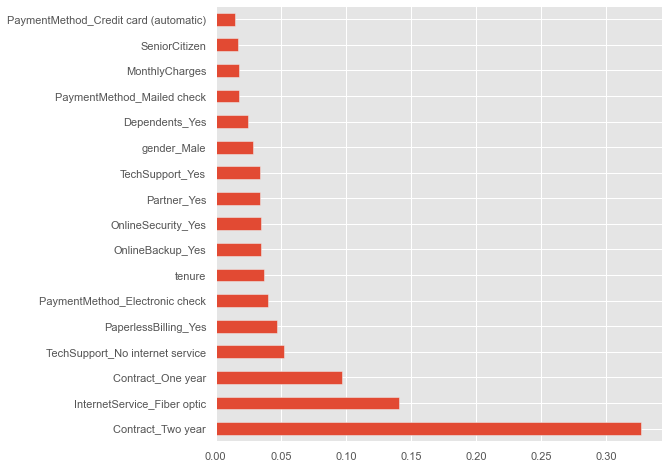

In [167]:
#Checking Feature Importance with XGB Model

feat_importances = pd.Series(xgb_model_final.feature_importances_, index=x.columns)
feat_importances.nlargest(100).plot(kind='barh',figsize=(8,8))

In [168]:
# load model and get predictions

model=joblib.load("Telecom_Churn.pkl")

#Predict

prediction = model.predict(x_test)

prediction

array([0, 1, 0, ..., 0, 1, 1])

In [169]:
pd.DataFrame([model.predict(x_test)[:], y_test[:]], index = ['Predicted', 'Original'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021